In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import utils_prep
import RNNEncoder
import RNNDecoder
import Attention

# Загрузка и анализ данных (№2, a)

In [3]:
df = pd.read_csv(r'data/babynames_extended.csv')

In [4]:
df

,Name,Gender,Name_RU
0,John,boy,Джон
1,William,boy,Уильям
2,James,boy,Джеймс
3,Charles,boy,Чарльз
4,George,boy,Джордж
...,...,...,...
6777,Laylah,girl,Лейла
6778,Carleigh,girl,Карли
6779,Kenley,girl,Кенли
6780,Sloane,girl,Слоан


In [4]:
df.Gender.value_counts()/df.shape[0]*100

Gender
boy     50.678266
girl    49.321734
Name: count, dtype: float64

# Подготовка данных (№2, b-d)

In [5]:
PAD_token = "."  # Padding
SOS_token = "<"  # Start Of Sequence
EOS_token = ">"  # End Of Sequence

In [6]:
df['Name'] = df['Name'].str.lower().str.strip()
df['Name_RU'] = df['Name_RU'].str.lower().str.strip()

In [7]:
eng_char2idx, eng_idx2char = utils_prep.build_vocab(df['Name'].tolist(), specials = [SOS_token, EOS_token, PAD_token])
rus_char2idx, rus_idx2char = utils_prep.build_vocab(df['Name_RU'].tolist(), specials = [SOS_token, EOS_token, PAD_token])

In [8]:
df[df['Name_RU'].str.contains(" ")]

,Name,Gender,Name_RU
712,ivory,boy,слоновая кость
962,gee,boy,ну и дела
1009,deforest,boy,вырубка леса
1235,josephus,boy,иосиф флавий
3818,arie,girl,орлиное гнездо
4528,nova,girl,новая звезда
5871,sunshine,girl,солнечный свет


In [9]:
X = [utils_prep.encode_name(name, eng_char2idx, SOS_token, EOS_token) for name in df['Name']]
y = [utils_prep.encode_name(name, rus_char2idx, SOS_token, EOS_token) for name in df['Name_RU']]

In [10]:
X_padded, X_max_length = utils_prep.pad_sequences(X, eng_char2idx[PAD_token])
y_padded, y_max_length = utils_prep.pad_sequences(y, rus_char2idx[PAD_token])

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y_padded, test_size=0.2, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [12]:
X_train_t = torch.tensor(X_train, dtype=torch.long)
X_valid_t = torch.tensor(X_valid, dtype=torch.long) 
X_test_t  = torch.tensor(X_test, dtype=torch.long)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_valid_t = torch.tensor(y_valid, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

In [13]:
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# RNN Encoder. №3

In [15]:
encoder = RNNEncoder.RNNEncoder(len(eng_char2idx))

In [16]:
num_epochs = 10

In [18]:
%%time
train_losses, valid_losses = RNNEncoder.train_rnn_encoder(
    encoder, train_loader, valid_loader, pad_idx = eng_char2idx[PAD_token], epochs=num_epochs
)

Epoch 1: 100%|██████████| 85/85 [00:02<00:00, 40.50it/s]


Epoch 1: Train=2.7112, Valid=2.4290


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 158.61it/s]


Epoch 2: Train=2.3363, Valid=2.2934


Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 154.51it/s]


Epoch 3: Train=2.2381, Valid=2.2287


Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 151.72it/s]


Epoch 4: Train=2.1835, Valid=2.1921


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 164.75it/s]


Epoch 5: Train=2.1471, Valid=2.1673


Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 169.66it/s]


Epoch 6: Train=2.1179, Valid=2.1468


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 168.08it/s]


Epoch 7: Train=2.0947, Valid=2.1267


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 157.00it/s]


Epoch 8: Train=2.0751, Valid=2.1151


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 171.61it/s]


Epoch 9: Train=2.0583, Valid=2.1054


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 176.95it/s]


Epoch 10: Train=2.0424, Valid=2.1018
CPU times: user 6.83 s, sys: 2.2 s, total: 9.03 s
Wall time: 10.1 s


In [20]:
generated_names = RNNEncoder.generate_names(encoder, sos_idx = eng_char2idx[SOS_token], eos_idx = eng_char2idx[EOS_token], pad_idx = eng_char2idx[PAD_token], eng_idx2char = eng_idx2char, max_len = X_max_length)
print("\nGenerated English names:")
for i, name in enumerate(generated_names, 1):
    print(f"{i:2d}. {name}")


Generated English names:
 1. deliss
 2. laisana
 3. warol
 4. zewal
 5. arlice
 6. olone
 7. camin
 8. kafetha
 9. kedora
10. chautlene


# RNN Machine Translation. Decoder. №4

In [21]:
encoder = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=64, hidden_size=64)

✅ Encoder загружен


In [28]:
rus_vocab_size = len(rus_char2idx)
decoder, train_losses, valid_losses = RNNDecoder.train_decoder(
    encoder, train_loader, valid_loader, len(rus_char2idx), eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx, 
                  X_train_t, X_valid_t, y_max_length, num_epochs, embed_size=64, hidden_size=64
)

Training Decoder (Encoder frozen)...


Epoch 1: 100%|██████████| 85/85 [00:03<00:00, 24.13it/s]


Epoch 1: Train=2.6302, Valid=2.2736


Epoch 2: 100%|██████████| 85/85 [00:03<00:00, 24.54it/s]


Epoch 2: Train=2.1211, Valid=2.0627
=== TRAIN SET ===
giuseppe  →джа | wallace   →джа | demarco   →мана | letitia   →джан | larkin    →кан

=== VALID SET ===
lou       →ка | roe       →джа | edgardo   →кана | catina    →джер | wing      →ман
--------------------------------------------------


Epoch 3: 100%|██████████| 85/85 [00:03<00:00, 23.85it/s]


Epoch 3: Train=1.9540, Valid=1.9760


Epoch 4: 100%|██████████| 85/85 [00:03<00:00, 23.81it/s]


Epoch 4: Train=1.8900, Valid=1.9263
=== TRAIN SET ===
giuseppe  →джан | wallace   →джер | demarco   →марин | letitia   →джерин | larkin    →кан

=== VALID SET ===
lou       →кан | roe       →джан | edgardo   →карин | catina    →джери | wing      →ман
--------------------------------------------------


Epoch 5: 100%|██████████| 85/85 [00:03<00:00, 24.25it/s]


Epoch 5: Train=1.8433, Valid=1.8995


Epoch 6: 100%|██████████| 85/85 [00:03<00:00, 24.33it/s]


Epoch 6: Train=1.7929, Valid=1.8654
=== TRAIN SET ===
giuseppe  →джарда | wallace   →джарин | demarco   →кардер | letitia   →джарин | larkin    →ханджин

=== VALID SET ===
lou       →карди | roe       →джарда | edgardo   →карджин | catina    →джерин | wing      →карин
--------------------------------------------------


Epoch 7: 100%|██████████| 85/85 [00:03<00:00, 24.05it/s]


Epoch 7: Train=1.7467, Valid=1.8383


Epoch 8: 100%|██████████| 85/85 [00:03<00:00, 24.28it/s]


Epoch 8: Train=1.7113, Valid=1.8170
=== TRAIN SET ===
giuseppe  →джарджерта | wallace   →джарджерта | demarco   →карджерли | letitia   →джарджерли | larkin    →харджер

=== VALID SET ===
lou       →карджерта | roe       →джарджерта | edgardo   →карджерлин | catina    →джерлин | wing      →марджан
--------------------------------------------------


Epoch 9: 100%|██████████| 85/85 [00:03<00:00, 24.89it/s]


Epoch 9: Train=1.6868, Valid=1.7779


Epoch 10: 100%|██████████| 85/85 [00:03<00:00, 25.00it/s]


Epoch 10: Train=1.6397, Valid=1.7528
=== TRAIN SET ===
giuseppe  →карджейли | wallace   →карджейли | demarco   →карджейли | letitia   →джерджейли | larkin    →фронджер

=== VALID SET ===
lou       →карджелла | roe       →карджейли | edgardo   →карджейлин | catina    →карджейли | wing      →марджен
--------------------------------------------------


In [24]:
RNNDecoder.check_translation(X_test_t, eng_char2idx, eng_idx2char, decoder, encoder, rus_char2idx, rus_idx2char, len(rus_char2idx), 10)

  geoff      → рейджель
  bush       → марджель
  landyn     → крейджан
  antone     → ремарджель
  naoma      → джерджелина
  freddy     → джергертина
  clarissa   → джерджерда
  graves     → джейджерд
  harriet    → арлинна
  tomika     → джерисана


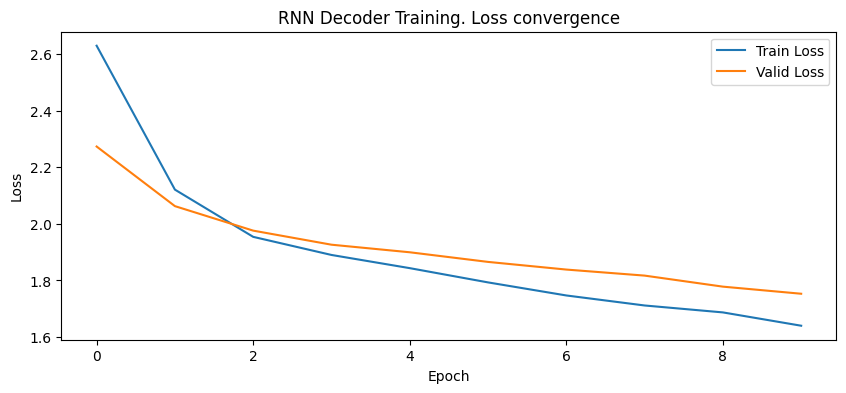

In [45]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(torch.tensor(valid_losses).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()
    

In [29]:
ppl = RNNDecoder.compute_perplexity(decoder, encoder, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 33.26


# Attention Machine Translation. №5

In [61]:
encoder = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=64, hidden_size=64)

✅ Encoder загружен


In [62]:
attention_decoder, attention_train_losses, attention_valid_losses = Attention.train_attention_decoder(
        encoder, train_loader, valid_loader, len(rus_char2idx), 
        eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx,
        X_train_t, X_valid_t, y_max_length, epochs=num_epochs
    )

Training Attention Decoder...


Epoch 1: 100%|██████████| 85/85 [00:00<00:00, 114.35it/s]


Epoch 1: Train=3.0519, Valid=2.7813


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 132.38it/s]


Epoch 2: Train=2.6588, Valid=2.5878
=== TRAIN SET ===
giuseppe  →ма | wallace   →мари | demarco   →мара | letitia   →дари | larkin    →дар

=== VALID SET ===
lou       →али | roe       →мари | edgardo   →мара | catina    →дара | wing      →мана
--------------------------------------------------


Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 124.14it/s]


Epoch 3: Train=2.4779, Valid=2.4358


Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 117.16it/s]


Epoch 4: Train=2.3380, Valid=2.3255
=== TRAIN SET ===
giuseppe  →кари | wallace   →арана | demarco   →марана | letitia   →джарана | larkin    →джан

=== VALID SET ===
lou       →дарли | roe       →джана | edgardo   →марана | catina    →дарана | wing      →карин
--------------------------------------------------


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 116.20it/s]


Epoch 5: Train=2.2388, Valid=2.2405


Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 127.27it/s]


Epoch 6: Train=2.1617, Valid=2.1779
=== TRAIN SET ===
giuseppe  →карин | wallace   →алана | demarco   →марана | letitia   →джарина | larkin    →джерли

=== VALID SET ===
lou       →анда | roe       →джарлин | edgardo   →джарина | catina    →данана | wing      →карлин
--------------------------------------------------


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 110.45it/s]


Epoch 7: Train=2.0993, Valid=2.1248


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 116.05it/s]


Epoch 8: Train=2.0436, Valid=2.0736
=== TRAIN SET ===
giuseppe  →алин | wallace   →алана | demarco   →марила | letitia   →джелия | larkin    →джерли

=== VALID SET ===
lou       →арон | roe       →джорон | edgardo   →джарина | catina    →анана | wing      →каннин
--------------------------------------------------


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 121.88it/s]


Epoch 9: Train=1.9893, Valid=2.0223


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 104.84it/s]


Epoch 10: Train=1.9391, Valid=1.9755
=== TRAIN SET ===
giuseppe  →алин | wallace   →алана | demarco   →марилан | letitia   →джелия | larkin    →джерлин

=== VALID SET ===
lou       →ароль | roe       →джоророн | edgardo   →джеророн | catina    →ананана | wing      →коннин
--------------------------------------------------


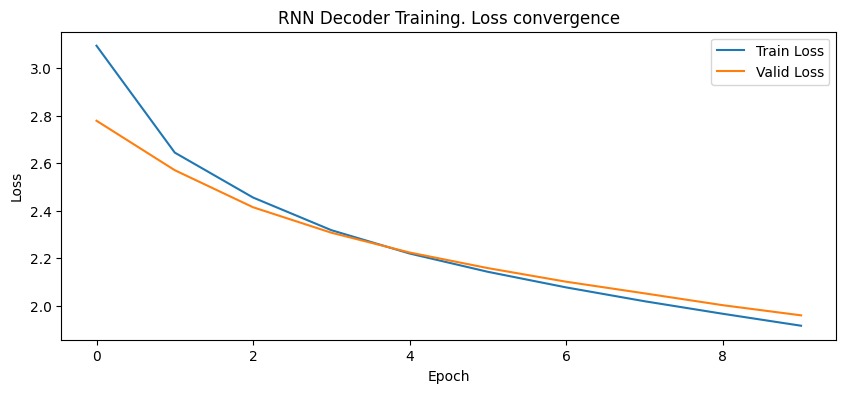

In [ ]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(attention_train_losses, label='Train Loss')
plt.plot(torch.tensor(attention_valid_losses).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()

In [65]:
ppl = Attention.compute_perplexity_attention(attention_decoder, encoder, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 19.17


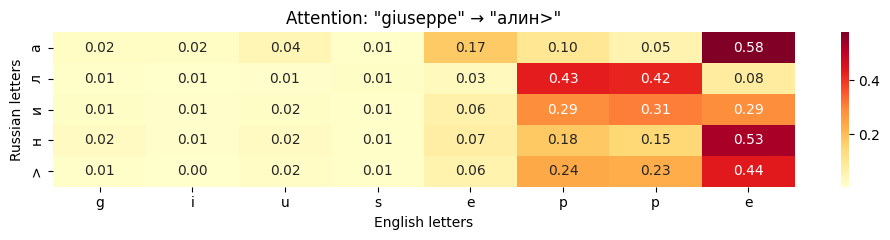

In [69]:
eng_indices = [eng_char2idx[c] for c in 'giuseppe']
eng_name, rus_name, attn_weights = Attention.visualize_attention(encoder, attention_decoder, eng_indices, 
                                                      eng_idx2char, rus_char2idx, rus_idx2char)
Attention.plot_attention_heatmap(eng_name, rus_name, attn_weights)

# Positional Encoding №6


# sin-cos

In [111]:
encoder_pos = RNNEncoder.RNNEncoder(len(eng_char2idx), pos_encoding = 'sine')

In [ ]:
%%time
train_losses, valid_losses = RNNEncoder.train_rnn_encoder(
    encoder_pos, train_loader, valid_loader, pad_idx = eng_char2idx[PAD_token], epochs=num_epochs, suffix = "pos"
)

Epoch 1:   9%|▉         | 8/85 [00:00<00:01, 56.48it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 1:  33%|███▎      | 28/85 [00:00<00:00, 88.49it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 1:  69%|██████▉   | 59/85 [00:00<00:00, 124.66it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 1: 100%|██████████| 85/85 [00:00<00:00, 113.61it/s]


embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 2:   0%|          | 0/85 [00:00<?, ?it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 2:  34%|███▍      | 29/85 [00:00<00:00, 143.79it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 2:  52%|█████▏    | 44/85 [00:00<00:00, 141.34it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 2:  71%|███████   | 60/85 [00:00<00:00, 144.76it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 142.59it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
Epoch 2: Train=2.3354, Valid=2.2895


Epoch 3:   0%|          | 0/85 [00:00<?, ?it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 3:  16%|█▋        | 14/85 [00:00<00:00, 134.95it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 3:  52%|█████▏    | 44/85 [00:00<00:00, 142.42it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 3:  69%|██████▉   | 59/85 [00:00<00:00, 144.01it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 3:  87%|████████▋ | 74/85 [00:00<00:00, 144.04it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 143.42it/s]


embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
Epoch 3: Train=2.2355, Valid=2.2

Epoch 4:  14%|█▍        | 12/85 [00:00<00:00, 110.96it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 4:  45%|████▍     | 38/85 [00:00<00:00, 121.73it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 4:  75%|███████▌  | 64/85 [00:00<00:00, 125.87it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 121.41it/s]


embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 5:   0%|          | 0/85 [00:00<?, ?it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 5:  15%|█▌        | 13/85 [00:00<00:00, 122.90it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 5:  32%|███▏      | 27/85 [00:00<00:00, 127.82it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 5:  47%|████▋     | 40/85 [00:00<00:00, 118.77it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 5:  61%|██████    | 52/85 [00:00<00:00, 114.39it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 5:  75%|███████▌  | 64/85 [00:00<00:00, 112.61it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 5:  92%|█████████▏| 78/85 [00:00<00:00, 121.08it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 119.66it/s]


embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 6:   0%|          | 0/85 [00:00<?, ?it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 6:  15%|█▌        | 13/85 [00:00<00:00, 124.14it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 6:  31%|███       | 26/85 [00:00<00:00, 124.90it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 6:  47%|████▋     | 40/85 [00:00<00:00, 127.67it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 6:  62%|██████▏   | 53/85 [00:00<00:00, 128.03it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 6:  79%|███████▉  | 67/85 [00:00<00:00, 130.20it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 127.28it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
Epoch 6: Train=2.1204, Valid=2.1500


Epoch 7:   0%|          | 0/85 [00:00<?, ?it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 7:  14%|█▍        | 12/85 [00:00<00:00, 117.70it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 7:  29%|██▉       | 25/85 [00:00<00:00, 119.89it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 7:  44%|████▎     | 37/85 [00:00<00:00, 116.83it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 7:  60%|██████    | 51/85 [00:00<00:00, 119.42it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 7:  74%|███████▍  | 63/85 [00:00<00:00, 113.16it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 7:  91%|█████████ | 77/85 [00:00<00:00, 119.48it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 117.66it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
Epoch 7: Train=2.0976, Valid=2.1

Epoch 8:   0%|          | 0/85 [00:00<?, ?it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 8:  14%|█▍        | 12/85 [00:00<00:00, 111.55it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 8:  28%|██▊       | 24/85 [00:00<00:00, 111.71it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 8:  44%|████▎     | 37/85 [00:00<00:00, 119.21it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 8:  59%|█████▉    | 50/85 [00:00<00:00, 120.20it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 8:  74%|███████▍  | 63/85 [00:00<00:00, 123.20it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 8:  91%|█████████ | 77/85 [00:00<00:00, 124.70it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 116.27it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
Epoch 8: Train=2.0770, Valid=2.1231


Epoch 9:   0%|          | 0/85 [00:00<?, ?it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 9:  14%|█▍        | 12/85 [00:00<00:00, 119.76it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 9:  28%|██▊       | 24/85 [00:00<00:00, 111.96it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 9:  42%|████▏     | 36/85 [00:00<00:00, 105.89it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 9:  55%|█████▌    | 47/85 [00:00<00:00, 106.04it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 9:  68%|██████▊   | 58/85 [00:00<00:00, 107.32it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 9:  82%|████████▏ | 70/85 [00:00<00:00, 109.52it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 9:  95%|█████████▌| 81/85 [00:00<00:00, 107.34it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 107.19it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
Epoch 9: Train=2.0598, Valid=2.1105


Epoch 10:   0%|          | 0/85 [00:00<?, ?it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 10:  14%|█▍        | 12/85 [00:00<00:00, 114.30it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 10:  31%|███       | 26/85 [00:00<00:00, 125.05it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 10:  46%|████▌     | 39/85 [00:00<00:00, 121.22it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 10:  61%|██████    | 52/85 [00:00<00:00, 119.53it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 10:  79%|███████▉  | 67/85 [00:00<00:00, 126.62it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe

Epoch 10:  95%|█████████▌| 81/85 [00:00<00:00, 127.73it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 122.36it/s]

embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu


embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
embedded.device:  cuda:0
self.pe.device: cpu
x.device:       cuda:0
pe_slice.device:cpu
Epoch 10: Train=2.0432, Valid=2.1036
CPU times: user 7.13 s, sys: 501 ms, total: 7.63 s
Wall time: 7.48 s


## RNN decoder

In [ ]:
encoder_pos = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=64, hidden_size=64, checkpoint_path = "best_encoder_pos.pth")

✅ Encoder загружен


In [114]:
rus_vocab_size = len(rus_char2idx)
decoder_pos, train_losses_pos, valid_losses_pos = RNNDecoder.train_decoder(
    encoder_pos, train_loader, valid_loader, len(rus_char2idx), eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx, 
                  X_train_t, X_valid_t, y_max_length, num_epochs, embed_size=64, hidden_size=64, suffix = "pos"
)

Training Decoder...


Epoch 1: 100%|██████████| 85/85 [00:03<00:00, 23.18it/s]


Epoch 1: Train=2.6274, Valid=2.2827


Epoch 2: 100%|██████████| 85/85 [00:03<00:00, 23.62it/s]


Epoch 2: Train=2.1618, Valid=2.0905
=== TRAIN SET ===
giuseppe  →дари | wallace   →кари | demarco   →мерин | letitia   →дари | larkin    →рина

=== VALID SET ===
lou       →элин | roe       →марин | edgardo   →дарин | catina    →дери | wing      →марин
--------------------------------------------------


Epoch 3: 100%|██████████| 85/85 [00:03<00:00, 23.52it/s]


Epoch 3: Train=1.9860, Valid=1.9836


Epoch 4: 100%|██████████| 85/85 [00:03<00:00, 23.35it/s]


Epoch 4: Train=1.8887, Valid=1.9127
=== TRAIN SET ===
giuseppe  →джери | wallace   →карин | demarco   →джерин | letitia   →джери | larkin    →рарин

=== VALID SET ===
lou       →рарди | roe       →карин | edgardo   →джерин | catina    →джерин | wing      →мардер
--------------------------------------------------


Epoch 5: 100%|██████████| 85/85 [00:03<00:00, 22.81it/s]


Epoch 5: Train=1.8210, Valid=1.8671


Epoch 6: 100%|██████████| 85/85 [00:03<00:00, 23.51it/s]


Epoch 6: Train=1.7596, Valid=1.8238
=== TRAIN SET ===
giuseppe  →карили | wallace   →карилин | demarco   →мерджерлин | letitia   →джердер | larkin    →джерлин

=== VALID SET ===
lou       →гарджер | roe       →карлинна | edgardo   →джерлин | catina    →джерлин | wing      →марлинна
--------------------------------------------------


Epoch 7: 100%|██████████| 85/85 [00:03<00:00, 22.20it/s]


Epoch 7: Train=1.7177, Valid=1.7752


Epoch 8: 100%|██████████| 85/85 [00:03<00:00, 23.90it/s]


Epoch 8: Train=1.6636, Valid=1.7604
=== TRAIN SET ===
giuseppe  →карина | wallace   →карилин | demarco   →марджерина | letitia   →карджери | larkin    →джерлин

=== VALID SET ===
lou       →грейлин | roe       →марлина | edgardo   →джерлина | catina    →джерлина | wing      →марлинна
--------------------------------------------------


Epoch 9: 100%|██████████| 85/85 [00:03<00:00, 23.62it/s]


Epoch 9: Train=1.6277, Valid=1.7432


Epoch 10: 100%|██████████| 85/85 [00:03<00:00, 22.60it/s]


Epoch 10: Train=1.6179, Valid=1.7225
=== TRAIN SET ===
giuseppe  →арлин | wallace   →карилин | demarco   →марджеллин | letitia   →кариллан | larkin    →джейлин

=== VALID SET ===
lou       →грейлин | roe       →марлина | edgardo   →джерлина | catina    →джейлина | wing      →марлинна
--------------------------------------------------


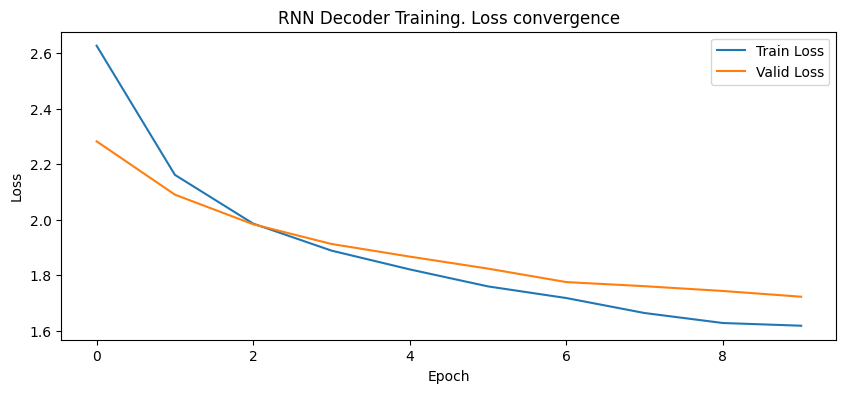

In [116]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses_pos, label='Train Loss')
plt.plot(torch.tensor(valid_losses_pos).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()
    

In [117]:
ppl = RNNDecoder.compute_perplexity(decoder_pos, encoder_pos, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 32.51


## Attention decoder

In [ ]:
encoder_pos = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=64, hidden_size=64, checkpoint_path = "best_encoder_pos.pth")

✅ Encoder загружен


In [118]:
attention_decoder_pos, attention_train_losses_pos, attention_valid_losses_pos = Attention.train_attention_decoder(
        encoder_pos, train_loader, valid_loader, len(rus_char2idx), 
        eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx,
        X_train_t, X_valid_t, y_max_length, epochs=num_epochs, suffix="pos"
    )

Training Attention Decoder...


Epoch 1: 100%|██████████| 85/85 [00:00<00:00, 87.61it/s] 


Epoch 1: Train=3.1429, Valid=2.7972


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 107.16it/s]


Epoch 2: Train=2.6544, Valid=2.5772
=== TRAIN SET ===
giuseppe  →кон | wallace   →кли | demarco   →кери | letitia   →кон | larkin    →лин

=== VALID SET ===
lou       →мери | roe       →керен | edgardo   →кли | catina    →кри | wing      →керри
--------------------------------------------------


Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 110.77it/s]


Epoch 3: Train=2.4686, Valid=2.4459


Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 106.57it/s]


Epoch 4: Train=2.3614, Valid=2.3740
=== TRAIN SET ===
giuseppe  →каррин | wallace   →керль | demarco   →карин | letitia   →керль | larkin    →лин

=== VALID SET ===
lou       →керль | roe       →керрин | edgardo   →карри | catina    →керрин | wing      →каррин
--------------------------------------------------


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 109.59it/s]


Epoch 5: Train=2.2993, Valid=2.3300


Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 109.23it/s]


Epoch 6: Train=2.2580, Valid=2.2978
=== TRAIN SET ===
giuseppe  →каррин | wallace   →карль | demarco   →карлин | letitia   →керль | larkin    →лин

=== VALID SET ===
lou       →керльджен | roe       →каррин | edgardo   →карри | catina    →керльджен | wing      →карльфэйлььшьшьша
--------------------------------------------------


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 110.53it/s]


Epoch 7: Train=2.2255, Valid=2.2686


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 107.92it/s]


Epoch 8: Train=2.1949, Valid=2.2372
=== TRAIN SET ===
giuseppe  →каррин | wallace   →керльджель | demarco   →керлин | letitia   →джейльджей | larkin    →лелльджейль

=== VALID SET ===
lou       →крейльфрин | roe       →керльфэйлььффрин | edgardo   →карлььджен | catina    →крейльджейль | wing      →кэлльфэйльфэйлььффэйлььффэйльь
--------------------------------------------------


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 107.75it/s]


Epoch 9: Train=2.1633, Valid=2.2152


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 108.11it/s]


Epoch 10: Train=2.1414, Valid=2.1937
=== TRAIN SET ===
giuseppe  →карринджа | wallace   →керльффрин | demarco   →крейльджен | letitia   →джейльджейль | larkin    →лелльфинджен

=== VALID SET ===
lou       →крейлльфинн | roe       →крейльфферль | edgardo   →карлььджен | catina    →крейлльджен | wing      →лелльфэйльффэйлььффрицжжан
--------------------------------------------------


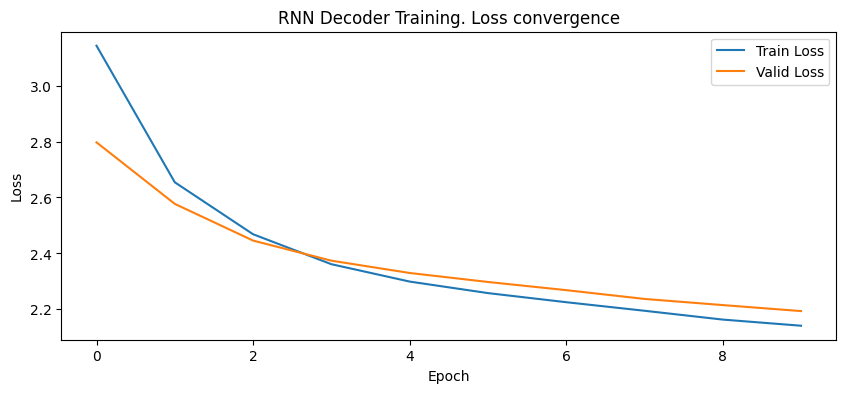

In [119]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(attention_train_losses_pos, label='Train Loss')
plt.plot(torch.tensor(attention_valid_losses_pos).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()

In [120]:
ppl = Attention.compute_perplexity_attention(attention_decoder_pos, encoder_pos, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 23.91


# trainable weights

In [123]:
encoder_weights = RNNEncoder.RNNEncoder(len(eng_char2idx), pos_encoding = 'weights')

In [124]:
%%time
train_losses, valid_losses = RNNEncoder.train_rnn_encoder(
    encoder_weights, train_loader, valid_loader, pad_idx = eng_char2idx[PAD_token], epochs=num_epochs, suffix = "weights"
)

Epoch 1: 100%|██████████| 85/85 [00:00<00:00, 129.17it/s]


Epoch 1: Train=2.7233, Valid=2.4263


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 160.45it/s]


Epoch 2: Train=2.3378, Valid=2.2977


Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 150.65it/s]


Epoch 3: Train=2.2423, Valid=2.2319


Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 163.33it/s]


Epoch 4: Train=2.1887, Valid=2.1913


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 159.95it/s]


Epoch 5: Train=2.1507, Valid=2.1693


Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 152.63it/s]


Epoch 6: Train=2.1231, Valid=2.1465


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 151.54it/s]


Epoch 7: Train=2.0994, Valid=2.1286


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 160.78it/s]


Epoch 8: Train=2.0795, Valid=2.1165


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 162.23it/s]


Epoch 9: Train=2.0612, Valid=2.1049


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 153.11it/s]

Epoch 10: Train=2.0451, Valid=2.0942
CPU times: user 5.61 s, sys: 325 ms, total: 5.93 s
Wall time: 5.92 s


## RNN decoder

In [ ]:
encoder_weights = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=64, hidden_size=64, checkpoint_path = "best_encoder_weights.pth")

✅ Encoder загружен


In [125]:
rus_vocab_size = len(rus_char2idx)
decoder_weights, train_losses_weights, valid_losses_weights = RNNDecoder.train_decoder(
    encoder_weights, train_loader, valid_loader, len(rus_char2idx), eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx, 
                  X_train_t, X_valid_t, y_max_length, num_epochs, embed_size=64, hidden_size=64, suffix = "weights"
)

Training Decoder...


Epoch 1:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 85/85 [00:03<00:00, 22.41it/s]


Epoch 1: Train=2.6206, Valid=2.2297


Epoch 2: 100%|██████████| 85/85 [00:03<00:00, 24.22it/s]


Epoch 2: Train=2.1097, Valid=2.0606
=== TRAIN SET ===
giuseppe  →дари | wallace   →дарин | demarco   →да | letitia   →ка | larkin    →арин

=== VALID SET ===
lou       →да | roe       →джен | edgardo   →дан | catina    →кари | wing      →кари
--------------------------------------------------


Epoch 3: 100%|██████████| 85/85 [00:03<00:00, 23.12it/s]


Epoch 3: Train=1.9719, Valid=1.9709


Epoch 4: 100%|██████████| 85/85 [00:03<00:00, 24.41it/s]


Epoch 4: Train=1.8878, Valid=1.9283
=== TRAIN SET ===
giuseppe  →джери | wallace   →джери | demarco   →джен | letitia   →джери | larkin    →арин

=== VALID SET ===
lou       →джен | roe       →джен | edgardo   →джен | catina    →кари | wing      →кари
--------------------------------------------------


Epoch 5: 100%|██████████| 85/85 [00:03<00:00, 24.39it/s]


Epoch 5: Train=1.8350, Valid=1.8873


Epoch 6: 100%|██████████| 85/85 [00:03<00:00, 24.05it/s]


Epoch 6: Train=1.7814, Valid=1.8571
=== TRAIN SET ===
giuseppe  →джейн | wallace   →джейн | demarco   →джейн | letitia   →кий | larkin    →ана

=== VALID SET ===
lou       →джейн | roe       →джейн | edgardo   →джейн | catina    →кийн | wing      →карин
--------------------------------------------------


Epoch 7: 100%|██████████| 85/85 [00:03<00:00, 23.86it/s]


Epoch 7: Train=1.7534, Valid=1.8405


Epoch 8: 100%|██████████| 85/85 [00:03<00:00, 23.32it/s]


Epoch 8: Train=1.7355, Valid=1.8223
=== TRAIN SET ===
giuseppe  →джейн | wallace   →джейли | demarco   →джейн | letitia   →джейн | larkin    →андин

=== VALID SET ===
lou       →джейн | roe       →джейн | edgardo   →джейн | catina    →кийн | wing      →джейн
--------------------------------------------------


Epoch 9: 100%|██████████| 85/85 [00:03<00:00, 24.82it/s]


Epoch 9: Train=1.6876, Valid=1.8077


Epoch 10: 100%|██████████| 85/85 [00:03<00:00, 23.85it/s]


Epoch 10: Train=1.6732, Valid=1.7980
=== TRAIN SET ===
giuseppe  →джейн | wallace   →джейли | demarco   →джейн | letitia   →джейна | larkin    →анана

=== VALID SET ===
lou       →джейн | roe       →джейн | edgardo   →джейн | catina    →джейна | wing      →джейна
--------------------------------------------------


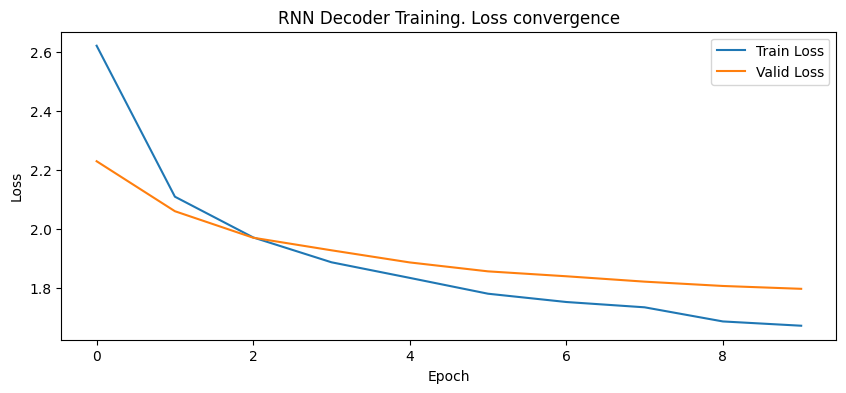

In [126]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses_weights, label='Train Loss')
plt.plot(torch.tensor(valid_losses_weights).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()
    

In [127]:
ppl = RNNDecoder.compute_perplexity(decoder_weights, encoder_weights, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 32.66


## Attention decoder

In [ ]:
encoder_weights = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=64, hidden_size=64, checkpoint_path = "best_encoder_weights.pth")

✅ Encoder загружен


In [135]:
attention_decoder_weights, attention_train_losses_weights, attention_valid_losses_weights = Attention.train_attention_decoder(
        encoder_weights, train_loader, valid_loader, len(rus_char2idx), 
        eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx,
        X_train_t, X_valid_t, y_max_length, epochs=num_epochs, suffix="weights"
    )

Training Attention Decoder...


Epoch 1: 100%|██████████| 85/85 [00:00<00:00, 106.18it/s]


Epoch 1: Train=3.1074, Valid=2.7871


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 129.75it/s]


Epoch 2: Train=2.6362, Valid=2.5536
=== TRAIN SET ===
giuseppe  →кан | wallace   →кари | demarco   →дари | letitia   →кели | larkin    →кан

=== VALID SET ===
lou       →кели | roe       →кери | edgardo   →дери | catina    →кони | wing      →элин
--------------------------------------------------


Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 134.79it/s]


Epoch 3: Train=2.4354, Valid=2.3967


Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 123.21it/s]


Epoch 4: Train=2.2976, Valid=2.2927
=== TRAIN SET ===
giuseppe  →кили | wallace   →кели | demarco   →джерин | letitia   →кели | larkin    →карин

=== VALID SET ===
lou       →кори | roe       →конна | edgardo   →кари | catina    →конин | wing      →манан
--------------------------------------------------


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 118.28it/s]


Epoch 5: Train=2.2033, Valid=2.2166


Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 131.40it/s]


Epoch 6: Train=2.1333, Valid=2.1630
=== TRAIN SET ===
giuseppe  →кили | wallace   →карлильли | demarco   →джерис | letitia   →карили | larkin    →каринан

=== VALID SET ===
lou       →элиль | roe       →конин | edgardo   →кари | catina    →конин | wing      →канина
--------------------------------------------------


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 124.76it/s]


Epoch 7: Train=2.0795, Valid=2.1189


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 122.07it/s]


Epoch 8: Train=2.0348, Valid=2.0796
=== TRAIN SET ===
giuseppe  →кари | wallace   →каллилальда | demarco   →джерис | letitia   →карили | larkin    →каринан

=== VALID SET ===
lou       →эльви | roe       →коринджен | edgardo   →карли | catina    →анини | wing      →канинан
--------------------------------------------------


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 124.20it/s]


Epoch 9: Train=1.9957, Valid=2.0431


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 126.78it/s]


Epoch 10: Train=1.9607, Valid=2.0142
=== TRAIN SET ===
giuseppe  →кария | wallace   →каллилальдальда | demarco   →карис | letitia   →калия | larkin    →кариннин

=== VALID SET ===
lou       →эльви | roe       →коринджери | edgardo   →карли | catina    →анинин | wing      →канинин
--------------------------------------------------


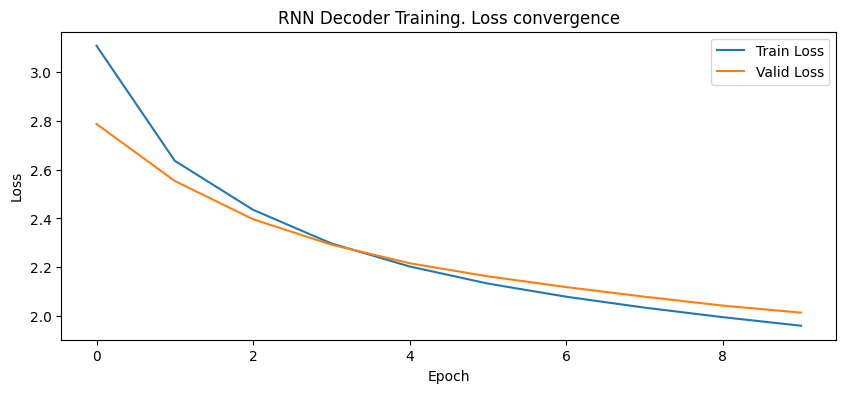

In [136]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(attention_train_losses_weights, label='Train Loss')
plt.plot(torch.tensor(attention_valid_losses_weights).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()

In [137]:
ppl = Attention.compute_perplexity_attention(attention_decoder_weights, encoder_weights, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 21.81


# Multi-head Attention Machine Translation. №7

In [ ]:
encoder_weights = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=64, hidden_size=64, checkpoint_path = "best_encoder_weights.pth")

In [146]:
attention_decoder_multi, attention_train_losses_multi, attention_valid_losses_multi = Attention.train_attention_decoder(
        encoder_weights, train_loader, valid_loader, len(rus_char2idx), 
        eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx,
        X_train_t, X_valid_t, y_max_length, epochs=num_epochs, suffix="multi", multi_head = True, n_heads = 8
    )

Training Attention Decoder...


Epoch 1:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 85/85 [00:00<00:00, 115.49it/s]


Epoch 1: Train=3.1031, Valid=2.7819


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 127.74it/s]


Epoch 2: Train=2.6410, Valid=2.5602
=== TRAIN SET ===
giuseppe  →эли | wallace   →мари | demarco   →ари | letitia   →ка | larkin    →кари

=== VALID SET ===
lou       →о | roe       →ори | edgardo   →дари | catina    →да | wing      →ди
--------------------------------------------------


Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 117.30it/s]


Epoch 3: Train=2.4466, Valid=2.4017


Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 121.81it/s]


Epoch 4: Train=2.3051, Valid=2.2902
=== TRAIN SET ===
giuseppe  →эли | wallace   →кари | demarco   →эли | letitia   →кари | larkin    →кара

=== VALID SET ===
lou       →он | roe       →джон | edgardo   →дари | catina    →кари | wing      →джин
--------------------------------------------------


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 117.49it/s]


Epoch 5: Train=2.2040, Valid=2.2067


Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 116.93it/s]


Epoch 6: Train=2.1238, Valid=2.1369
=== TRAIN SET ===
giuseppe  →элин | wallace   →эльва | demarco   →эль | letitia   →кайли | larkin    →каран

=== VALID SET ===
lou       →он | roe       →джори | edgardo   →эль | catina    →кари | wing      →кина
--------------------------------------------------


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 129.23it/s]


Epoch 7: Train=2.0568, Valid=2.0783


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 123.22it/s]


Epoch 8: Train=1.9974, Valid=2.0233
=== TRAIN SET ===
giuseppe  →элин | wallace   →карана | demarco   →карана | letitia   →кайла | larkin    →карана

=== VALID SET ===
lou       →он | roe       →кори | edgardo   →карина | catina    →карин | wing      →кина
--------------------------------------------------


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 128.33it/s]


Epoch 9: Train=1.9387, Valid=1.9681


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 127.02it/s]


Epoch 10: Train=1.8844, Valid=1.9192
=== TRAIN SET ===
giuseppe  →кистина | wallace   →караранана | demarco   →карана | letitia   →кайлайла | larkin    →карана

=== VALID SET ===
lou       →она | roe       →коррон | edgardo   →карана | catina    →кайли | wing      →кирина
--------------------------------------------------


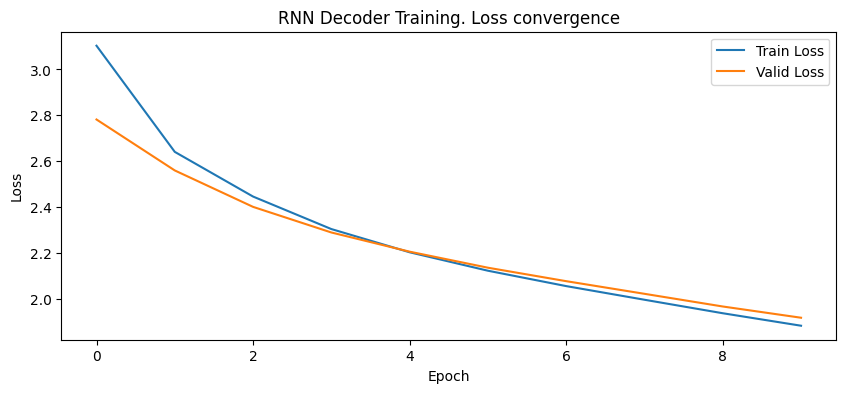

In [147]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(attention_train_losses_multi, label='Train Loss')
plt.plot(torch.tensor(attention_valid_losses_multi).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()

In [148]:
ppl = Attention.compute_perplexity_attention(attention_decoder_multi, encoder_weights, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 12.68
